**Họ tên:** _[Phan Sĩ Nguyên]_  
**Email:** _[psinguyenz@gmail.com]_  

---

**⚠️ LƯU Ý QUAN TRỌNG:**
- Notebook này đã được update để tương thích với transformers >= 4.30 và TRL >= 0.7
- Hãy chạy tất cả cells theo thứ tự từ trên xuống dưới
- Đảm bảo chọn GPU runtime: Runtime > Change runtime type > GPU (T4)

## ⚙️ Setup Environment

In [ ]:
import torch
import warnings
warnings.filterwarnings('ignore')

print(f"🔥 CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("⚠️ GPU not available. Please enable GPU in Runtime settings.")

🔥 CUDA Available: True
GPU Device: Tesla T4
GPU Memory: 15.83 GB


Bonus wandb

In [ ]:
!pip install -q wandb
import wandb
wandb.login()

wandb: Currently logged in as: akaksakanzjzn (akaksakanzjzn-none) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

Bonus Gradio Demo

In [ ]:
# Cài đặt thư viện Gradio
!pip install -q gradio

# Gói LangChain cốt lõi
!pip install langchain

!pip install langchain-community

!pip install langchain-core

!pip install -q sentence-transformers

!pip install langchain-text-splitters

# Gói để làm việc với Vector Database (Ví dụ: ChromaDB)
!pip install chromadb

---

# 📝 BÀI 1: KHỞI ĐỘNG VỚI LLM (20 điểm)

## 1.1. Cài đặt thư viện cần thiết

In [ ]:
# TODO: Cài đặt các thư viện cần thiết
# Gợi ý: transformers, torch, accelerate, bitsandbytes

!pip install -q transformers accelerate bitsandbytes sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 15.0 MB/s eta 0:00:00


In [ ]:
!pip show transformers accelerate bitsandbytes sentencepiece | grep -E 'Name:|Version:'

Name: transformers
Version: 4.57.3
Name: accelerate
Version: 1.12.0
Name: bitsandbytes
Version: 0.49.0
Name: sentencepiece
Version: 0.2.1


## 1.2. Load model và tokenizer

**TODO:** Load mô hình Qwen/Qwen2.5-1.5B-Instruct

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

model_name = "Qwen/Qwen2.5-1.5B-Instruct"

# TODO: Load tokenizer
# Gợi ý: AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

# TODO: Load model với 4-bit quantization
# Gợi ý: AutoModelForCausalLM.from_pretrained() với các tham số:
#   - device_map="auto"
#   - load_in_4bit=True
#   - trust_remote_code=True
#   - torch_dtype=torch.float16

# Khi print ra có lỗi "The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions." nên có thể truyền vào từ biến BitsAndBytesConfig
# Cấu hình 4-bit Quantization (NF4)
# bnb_config = BitsAndBytesConfig(
#     load_in_4bit=True,
#     bnb_4bit_quant_type="nf4",
#     bnb_4bit_compute_dtype=torch.bfloat16,
#     bnb_4bit_use_double_quant=True,
# )

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    # quantization_config=bnb_config,
    load_in_4bit=True,
    trust_remote_code=True,
    torch_dtype=torch.float16
)

`torch_dtype` is deprecated! Use `dtype` instead!
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


## 1.3. Inference với test prompts

**TODO:** Chạy inference với 3 prompts được cho

In [ ]:
test_prompts = [
    "What is machine learning?",
    "Explain neural networks in simple terms.",
    "What are the benefits of fine-tuning LLMs?"
]

def generate_response(prompt, max_new_tokens=200):
    """
    Generate response from model given a prompt

    Gợi ý:
    1. Format prompt theo chat template: tokenizer.apply_chat_template()
    2. Tokenize input: tokenizer([text], return_tensors="pt").to(model.device)
    3. Generate: model.generate() với các tham số phù hợp
    4. Decode output: tokenizer.decode()
    5. Extract assistant response
    """
    # TODO: Implement inference logic
    messages = [
        {"role": "user", "content": prompt}
    ]

    # 1. Format prompt theo chat template: tokenizer.apply_chat_template()
    text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

    # 2. Tokenize input: tokenizer([text], return_tensors="pt").to(model.device)
    inputs = tokenizer([text], return_tensors="pt").to(model.device)

    # 3. Generate: model.generate() với các tham số phù hợp
    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True, # Bật sample để chọn token dựa theo phân phối xác suất
            temperature=0.7, # Thiết lập độ "sáng tạo"
            top_p=0.9, # Kiểm soát phân phối xác suất
            eos_token_id=tokenizer.eos_token_id
        )

    # 4. Decode output: tokenizer.decode()
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=False)

    # 5. Extract assistant response
    assistant_prefix = "<|im_start|>assistant\n"
    # Tìm vị trí bắt đầu của câu trả lời assistant
    start_index = generated_text.find(assistant_prefix)
    if start_index != -1:
        # Cắt chuỗi từ vị trí bắt đầu của assistant
        response_with_end_tokens = generated_text[start_index + len(assistant_prefix):]
        # Loại bỏ token kết thúc (end token) và khoảng trắng thừa
        response = response_with_end_tokens.split("<|im_end|>")[0].strip()
    else:
        # Nếu không tìm thấy, trả về toàn bộ chuỗi đã decode (trừ input)
        # Hoặc một logic chiết xuất đơn giản hơn nếu không dùng chat template
        input_len = inputs['input_ids'].shape[1]
        response = tokenizer.decode(output_ids[0, input_len:], skip_special_tokens=True).strip()
    return response

# TODO: Chạy inference cho từng prompt và in kết quả
for i, prompt in enumerate(test_prompts, 1):
    response = generate_response(prompt)
    print(f"\n{'='*60}")
    print(f"PROMPT {i}: {prompt}")
    print(f"{'='*60}")
    print(f"MODEL RESPONSE:\n{response}")
    # Gọi generate_response() và in kết quả


PROMPT 1: What is machine learning?
MODEL RESPONSE:
Machine learning (ML) is an application of artificial intelligence (AI). It provides computer systems the capability to automatically learn and improve from experience without being explicitly programmed.

In simpler terms, ML involves creating algorithms that can analyze data sets and identify patterns or trends in them. These algorithms use statistical techniques to make predictions or decisions with limited human intervention. They can be used for various tasks like image recognition, speech recognition, natural language processing, and more. Machine learning models can process large amounts of data quickly and accurately, making it possible to build intelligent applications that can adapt and respond to new inputs.

The development of machine learning requires expertise in statistics, mathematics, programming, and domain knowledge. It also involves understanding how different algorithms work, what features they require, and how r

## 1.4. [BONUS] Đo thời gian và VRAM usage

**TODO:** Đo thời gian inference và memory usage

In [ ]:
import time

# TODO: Implement timing và memory tracking
# Gợi ý:
# - torch.cuda.memory_allocated() / 1e9 để get memory usage
# - torch.cuda.max_memory_allocated() / 1e9 cho peak memory
# - time.time() để đo thời gian
DEVICE = model.device
for i, prompt in enumerate(test_prompts, 1):
    # 1. Reset bộ đếm bộ nhớ để đo chính xác cho từng prompt riêng biệt
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats(DEVICE)

    # 2. Đồng bộ hóa GPU trước khi bắt đầu tính giờ
    torch.cuda.synchronize(DEVICE)
    start_time = time.time()
    initial_allocated_memory = torch.cuda.memory_allocated(DEVICE) / 1e9

    response = generate_response(prompt)

    torch.cuda.synchronize(DEVICE)
    end_time = time.time()

    peak_allocated_memory = torch.cuda.max_memory_allocated(DEVICE) / 1e9
    final_allocated_memory = torch.cuda.memory_allocated(DEVICE) / 1e9
    execution_time = end_time - start_time
    print(f"\n{'='*60}")
    print(f"PROMPT {i}: {prompt}")
    print(f"{'='*60}")
    print(f"MODEL RESPONSE:\n{response}")
    print("\n--- METRICS ---")
    print(f"Execution Time: **{execution_time:.4f} seconds**")
    print(f"Device: {DEVICE}")
    print(f"VRAM Allocated BEFORE Generation (Model + Input): {initial_allocated_memory:.3f} GB")
    print(f"Peak VRAM Usage DURING Generation: **{peak_allocated_memory:.3f} GB**")
    print(f"VRAM Allocated AFTER Generation: {final_allocated_memory:.3f} GB")


PROMPT 1: What is machine learning?
MODEL RESPONSE:
Machine learning is the field of study that deals with developing algorithms and statistical models to perform specific tasks without being explicitly programmed. It involves using data sets to build predictive models or decision-making systems. Machine learning applications can range from simple pattern recognition (like spam filtering) to complex prediction and analysis of large datasets.

Here's a more detailed breakdown:

1. **Supervised Learning**: In this approach, you provide labeled data (i.e., data paired with correct answers). The algorithm learns patterns from these examples to make predictions on new, unseen data.

2. **Unsupervised Learning**: Here, you have unlabeled data where no predefined labels are provided. The goal is to find structure in the data through clustering or association rules.

3. **Reinforcement Learning**: This type of learning focuses on making decisions based on rewards and penalties received for di

---

# 📚 BÀI 2: LÝ THUYẾT VỀ FINE-TUNING (20 điểm)

## 2.1. So sánh các phương pháp fine-tuning

**TODO:** Viết câu trả lời của bạn ở đây

### Full Fine-tuning
- **Ưu điểm:**
  - Độ chính xác cao nhất vì mọi trọng số đều được hiệu chỉnh.
- **Nhược điểm:**
  - Chi phí tài nguyên rất  để lưu trữ và tính toán cho toàn bộ mô hình. Thời gian huấn luyện dài hơn.
- **Khi nào sử dụng:**
  - Khi mô hình nhỏ hoặc khi cần đạt hiệu suất tối đa với tài nguyên GPU không giới hạn

### LoRA (Low-Rank Adaptation)
- **Ưu điểm:**
  - Tiết kiệm tài nguyên và tốc độ do chỉ chỉnh tham số của ma trận A và B của ma trận thêm nên giảm rất nhiều tham số huấn luyện.
- **Nhược điểm:**
  - Hiệu suất thấp hơn so với Full Fine-tuning.
- **Khi nào sử dụng:**
  - Khi mô hình lớn hoặc khi cần huấn luyện nhanh chóng, hiệu quả hoặc thử nghiệm nhiều tham số, bộ dữ liệu khác nhau

### QLoRA
- **Ưu điểm:**
  - Siêu tiết kiệm VRAM, kết hợp LoRA với 4-bit NormalFloat (NF4) quantization để giảm kích thước bộ nhớ của mô hình xuống 4 lần và double quantization để tiếp tục tiết kiệm thêm bộ nhớ. (~0.1% của W0)
- **Nhược điểm:**
  - Tốc độ chậm hơn LoRA thuần
- **Khi nào sử dụng:**
  - Khi mô hình rất lớn và có VRAM bị giới hạn

---

## 2.2. Các hyperparameters quan trọng

**TODO:** Giải thích vai trò của từng hyperparameter

### Learning Rate
- Kiểm soát mức độ điều chỉnh trọng số của mô hình trong mỗi bước tối ưu hóa. LR quá cao sẽ giúp mô hình học nhanh nhưng có thể sẽ bỏ qua điểm cự tiểu, LR quá thấp sẽ làm mô hình bị chậm hoặc mắc kẹt ở local minimum.

### Batch Size
- Số lượng mẫu dữ liệu được xử lí đồng thời trước khi trọng số được cập nhật, giúp tăng tốc độ tính toán. Batch size lớn giúp ước tính gradient chính xác hơn nhưng yêu cầu nhiều VRAM hơn. Batch size nhỏ sử dụng ít VRAM hơn nhưng ước tính gradient bị nhiễu hơn.

### LoRA Rank (r) và LoRA Alpha
- Rank là kích thước inner dimension của ma trận A và B. Rank thấp phù hợp học các thay đổi đơn giản còn rank cao phù hợp học các chi tiết phúc tạp nhưng tốn nhiều VRAM hơn.
- LoRA Alpha là một hệ số khuếch đại các trọng số mới theo một tỉ lệ nhất định so với r để chuẩn hóa đầu ra với nhiều giá trị của r mà không sợ mô hình bị gradient explosion.

### Số Epochs
- Số lần train toàn bộ bộ dữ liệu. Epochs quá lớn sẽ dễ bị overfitting còn epochs quá bé thì thuật toán có thể chưa hội tụ về điểm tối ưu.

### Warmup Steps
- Là số vòng điều chỉnh Learning Rate tăng tuyến tính sau mỗi bước. Khi đạt LR max, LR sẽ giảm dần để mô hình tìm thấy LR tối ưu.

---

## 2.3. Overfitting và cách phòng tránh

**TODO:** Liệt kê ít nhất 3 kỹ thuật để tránh overfitting

1. Sử dụng Regularization L2/Weight Decay: Thêm một thành phần (tính theo biến lambda) giúp giảm các trọng số và giảm độ phức tạp của mô hình và tránh bị overfit.

2. Early Stopping: Theo dõi hiệu suất trên validation set và nếu hiệu suất không cải thiện thì sẽ dừng quá trình train sớm để tránh bị overfit trên bộ dữ liệu train.

3. Dropout: Thêm 1 biến tỉ lệ % một nơ ron bị disable trong mỗi bước để mô hình tránh phụ thuộc vào 1 nhóm cụ thể để đưa ra dự đoán.

---

# 🔧 BÀI 3: FINE-TUNING LLM (40 điểm)

## 3.1. Cài đặt thư viện cho fine-tuning

In [ ]:
# TODO: Cài đặt các thư viện cần thiết
# Gợi ý: peft, datasets

!pip install -q peft datasets

In [ ]:
!pip show peft datasets | grep -E 'Name:|Version:'

Name: peft
Version: 0.18.0
Name: datasets
Version: 4.0.0


## 3.2. Load và khám phá dataset

In [ ]:
from datasets import load_dataset

# TODO: Load dataset 'ruslanmv/ai-medical-chatbot'
# Gợi ý: load_dataset("ruslanmv/ai-medical-chatbot")
dataset = load_dataset("ruslanmv/ai-medical-chatbot")

# TODO: Khám phá cấu trúc dữ liệu
# - In ra số lượng samples
# - In ra 2-3 examples
# - Xem các fields có trong dataset

print(dataset.column_names)
data_split = dataset['train']
num_samples = len(data_split)
print(f"✅ Số lượng samples: {num_samples}")
print("-" * 40)

print("✅ 3 Examples ngẫu nhiên:")
import random
random_indices = random.sample(range(num_samples), 3)
random_examples = data_split[random_indices]
print(random_examples)
print("-" * 40)

fields = data_split.features
print("✅ Các fields (cột) trong dataset:")
print(fields)
print("-" * 40)

{'train': ['Description', 'Patient', 'Doctor']}
✅ Số lượng samples: 256916
----------------------------------------
✅ 3 Examples ngẫu nhiên:
{'Description': ['How can blood sugar levels be kept under control?', 'Are ALT and MRSA related ?', 'What causes tingling sensation and numbness in the hands?'], 'Patient': ['I recently had a blood sugar test and the results were at 6. My doctor prescribed metformin but I wan unable to tolerate it. She took me off and i am watching my diet. I test my blood sugar daily and it has been running between 103 and tonight it was 116. Is this too high?', 'my ALT was 67 but all other test were good, Except possibly Mrsa in my leg waiting for results. Would that raisr ALT?', 'I loose flood flow to my hands at night when I go to bed, they first get hot then start tingling and then they go numb and I cannot get to sleep and if I do fall asleep my hand wake me up. I m 54 in good shape hardcore mountain biker, ex athlete (football) 6 -0 210 lbs'], 'Doctor': ['H

## 3.3. Thống kê dữ liệu

**TODO:** Thực hiện các thống kê được yêu cầu

Map:   0%|          | 0/256916 [00:00<?, ? examples/s]

--- PHÂN TÍCH THỐNG KÊ ĐỘ DÀI DỮ LIỆU ---
1. Tổng số Samples: 256916

2. Phân bố Độ dài (Số từ):
| Metric   |   Patient Question Length (words) |   Doctor Answer Length (words) |
|:---------|----------------------------------:|-------------------------------:|
| Min      |                              1    |                           1    |
| Max      |                           3672    |                        1867    |
| Median   |                             69    |                          79    |
| Mean     |                             83.59 |                          89.33 |
| Std Dev  |                             56.22 |                          56.75 |

3. Vẽ Histogram Phân bố Độ dài (Basic Plot):


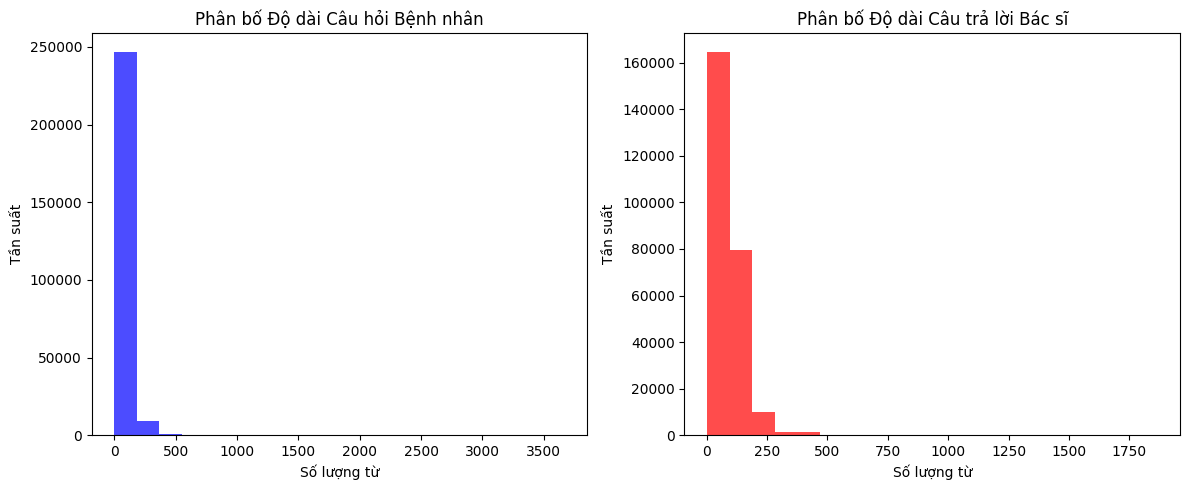


4. Vẽ Histogram Phân bố Độ dài (Zoom: 0-500 từ):


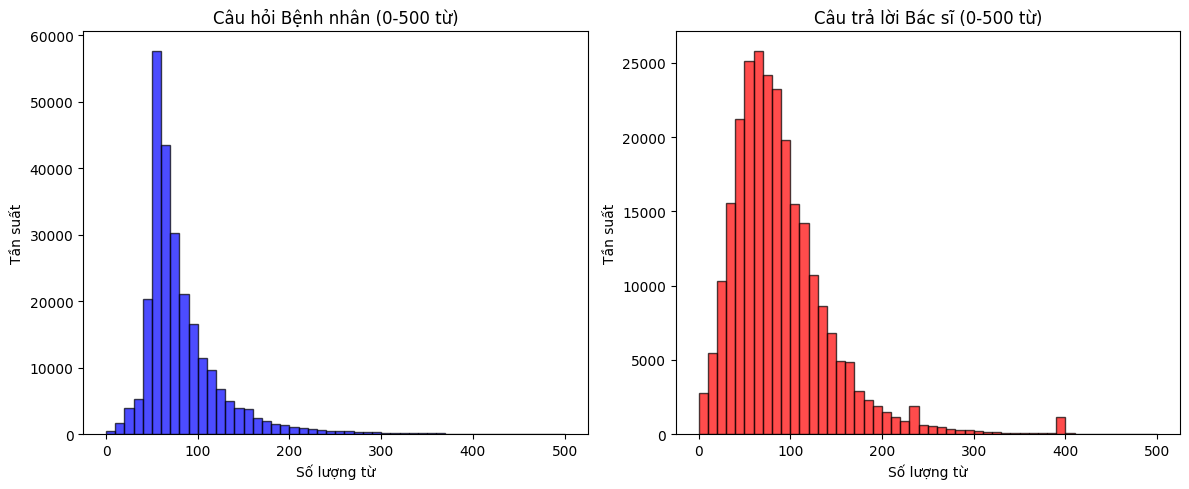

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# TODO:
# - Tổng số samples
# - Độ dài trung bình của questions và answers (số words)
# - Phân bố độ dài (min, max, median, std)
# - Vẽ histogram phân bố độ dài

# Code của bạn ở đây
import pandas as pd

# Hàm tính độ dài (số từ)
def calculate_length(text):
    if text is None:
        return 0
    return len(str(text).split())

data_split = data_split.map(
    lambda x: {
        'patient_len': calculate_length(x['Patient']),
        'doctor_len': calculate_length(x['Doctor'])
    },
    num_proc=1
)

patient_lengths = data_split['patient_len']
doctor_lengths = data_split['doctor_len']

# ----------------------------------------------------
# PHÂN TÍCH THỐNG KÊ
# ----------------------------------------------------
print("--- PHÂN TÍCH THỐNG KÊ ĐỘ DÀI DỮ LIỆU ---")

# Tổng số samples
total_samples = len(data_split)
print(f"1. Tổng số Samples: {total_samples}")

# Tạo DataFrame thống kê
stats = {
    'Metric': ['Min', 'Max', 'Median', 'Mean', 'Std Dev'],
    'Patient Question Length (words)': [
        np.min(patient_lengths),
        np.max(patient_lengths),
        np.median(patient_lengths),
        np.mean(patient_lengths),
        np.std(patient_lengths)
    ],
    'Doctor Answer Length (words)': [
        np.min(doctor_lengths),
        np.max(doctor_lengths),
        np.median(doctor_lengths),
        np.mean(doctor_lengths),
        np.std(doctor_lengths)
    ]
}

stats_df = pd.DataFrame(stats).round(2)
print("\n2. Phân bố Độ dài (Số từ):")
print(stats_df.to_markdown(index=False))

# ----------------------------------------------------
# TRỰC QUAN HÓA (Biểu đồ basic)
# ----------------------------------------------------
print("\n3. Vẽ Histogram Phân bố Độ dài (Basic Plot):")


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Histogram cho Patient Question Length
axes[0].hist(patient_lengths, bins=20, color='blue', alpha=0.7)
axes[0].set_title('Phân bố Độ dài Câu hỏi Bệnh nhân')
axes[0].set_xlabel('Số lượng từ')
axes[0].set_ylabel('Tần suất')

# Histogram cho Doctor Answer Length
axes[1].hist(doctor_lengths, bins=20, color='red', alpha=0.7)
axes[1].set_title('Phân bố Độ dài Câu trả lời Bác sĩ')
axes[1].set_xlabel('Số lượng từ')
axes[1].set_ylabel('Tần suất')

plt.tight_layout()
plt.show()

# ----------------------------------------------------
# PHẦN VẼ THÊM (Zoom vào 0-500 từ) (vì độ dài của câu hỏi cũng như câu trả lời thường nằm trong khoảng dưới 500 từ)
# ----------------------------------------------------
print("\n4. Vẽ Histogram Phân bố Độ dài (Zoom: 0-500 từ):")

# Tạo một figure MỚI để không bị lỗi index với figure cũ
fig_zoom, axes_zoom = plt.subplots(1, 2, figsize=(12, 5))

# Histogram cho Patient (0-500)
# Dùng tham số range=(0, 500) để giới hạn dữ liệu vẽ
axes_zoom[0].hist(patient_lengths, bins=50, range=(0, 500), color='blue', alpha=0.7, edgecolor='black')
axes_zoom[0].set_title('Câu hỏi Bệnh nhân (0-500 từ)')
axes_zoom[0].set_xlabel('Số lượng từ')
axes_zoom[0].set_ylabel('Tần suất')

# Histogram cho Doctor (0-500)
# Dùng tham số range=(0, 500) để giới hạn dữ liệu vẽ
axes_zoom[1].hist(doctor_lengths, bins=50, range=(0, 500), color='red', alpha=0.7, edgecolor='black')
axes_zoom[1].set_title('Câu trả lời Bác sĩ (0-500 từ)')
axes_zoom[1].set_xlabel('Số lượng từ')
axes_zoom[1].set_ylabel('Tần suất')

plt.tight_layout()
plt.show()

## 3.4. Tiền xử lý và format dữ liệu

**TODO:** Format dữ liệu theo chuẩn instruction-following

In [ ]:
from datasets import Dataset
import os

SYSTEM_PROMPT = "You are a professional and detailed medical assistant, providing information based on scientific evidence."

def format_instruction(sample):
    """
    Format sample theo chuẩn ChatML của Qwen

    Expected format:
    <|im_start|>system
    {system_message}<|im_end|>
    <|im_start|>user
    {question}<|im_end|>
    <|im_start|>assistant
    {answer}<|im_end|>

    Gợi ý: Dataset có fields 'Patient' (question) và 'Doctor' (answer)
    """
    # TODO: Implement formatting logic
    text = (
        f"<|im_start|>system\n{SYSTEM_PROMPT}<|im_end|>\n"
        f"<|im_start|>user\n{sample['Patient']}\n<|im_end|>\n"
        f"<|im_start|>assistant\n{sample['Doctor']}<|im_end|>"
    )
    return {"text": text}

# TODO: Apply formatting
# 1. Loop qua dataset và format từng sample
# 2. Tạo list các samples đã format với field 'text'
# 3. Convert sang Dataset object
# 4. Shuffle và limit 1000 samples
# 5. Split train/validation (90/10)

# 1. Loop qua dataset và format từng sample
# 2. Tạo list các samples đã format với field 'text'
formatted_samples_list = []
for sample in data_split:
    formatted_dict = format_instruction(sample)
    formatted_samples_list.append(formatted_dict)

# 3. Convert sang Dataset object
formatted_dataset = Dataset.from_list(formatted_samples_list)
print("\nNội dung của mẫu đầu tiên:")
print(formatted_dataset[0]['text'])

# 4. Shuffle và limit 1000 samples
TARGET_SAMPLES = 1000
SEED = 42

# Xáo trộn toàn bộ dataset
shuffled_dataset = formatted_dataset.shuffle(seed=SEED)

# Giới hạn số lượng samples
if len(shuffled_dataset) > TARGET_SAMPLES:
    limited_dataset = shuffled_dataset.select(range(TARGET_SAMPLES))
    print(f"✅ Đã giới hạn dataset còn {TARGET_SAMPLES} mẫu.")
else:
    limited_dataset = shuffled_dataset
    print(f"Số mẫu ({len(limited_dataset)}) ít hơn {TARGET_SAMPLES}, không giới hạn.")
print("-" * 40)

# 5. Split train/validation (90/10)
split_ratio = 0.1
split_datasets = limited_dataset.train_test_split(test_size=split_ratio, seed=SEED)

train_dataset = split_datasets['train']
val_dataset = split_datasets['test']

print("✅ Chia Train/Validation hoàn tất:")
print(f"  - Train Set: {len(train_dataset)} mẫu")
print(f"  - Validation Set: {len(val_dataset)} mẫu")


Nội dung của mẫu đầu tiên:
<|im_start|>system
You are a professional and detailed medical assistant, providing information based on scientific evidence.<|im_end|>
<|im_start|>user
Hi doctor,I am just wondering what is abutting and abutment of the nerve root means in a back issue. Please explain. What treatment is required for annular bulging and tear?
<|im_end|>
<|im_start|>assistant
Hi. I have gone through your query with diligence and would like you to know that I am here to help you. For further information consult a neurologist online --><|im_end|>
✅ Đã giới hạn dataset còn 1000 mẫu.
----------------------------------------
✅ Chia Train/Validation hoàn tất:
  - Train Set: 900 mẫu
  - Validation Set: 100 mẫu


## 3.5. Cấu hình LoRA

**TODO:** Setup LoRA configuration và apply vào model

In [ ]:
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

# TODO: Prepare model for training
# Gợi ý:
# 1. model.gradient_checkpointing_enable()
# 2. model = prepare_model_for_kbit_training(model)
model.gradient_checkpointing_enable() # Chỉ lưu các activations của một số lớp được chọn (checkpoint) trong Forward Pass để giảm VRAM
model = prepare_model_for_kbit_training(model) # Đảm bảo tính ổn định và tương thích khi finetune trên trọng số 4bit

# TODO: Cấu hình LoRA parameters
# Gợi ý:
# - r=8-16 (rank)
# - lora_alpha=16-32 (thường = 2*r)
# - target_modules=["q_proj", "k_proj", "v_proj", "o_proj", ...]
# - lora_dropout=0.05
# - bias="none"
# - task_type="CAUSAL_LM"

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"], # Query, Key, Value, Output trong Attention
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)

# TODO: Apply LoRA to model
model = get_peft_model(model, lora_config)

# TODO: In ra số trainable parameters
model.print_trainable_parameters()

trainable params: 4,358,144 || all params: 1,548,072,448 || trainable%: 0.2815


## 3.6. Cấu hình Training Arguments

**TODO:** Setup training arguments

In [ ]:
from transformers import TrainingArguments

# TODO: Cấu hình training arguments
# LƯU Ý: Dùng eval_strategy thay vì evaluation_strategy (transformers >= 4.30)

training_args = TrainingArguments(
    output_dir="./qwen-medical-finetuned",

    # TODO: Cấu hình các tham số training
    # - num_train_epochs=1-3
    # - per_device_train_batch_size=2-4
    # - gradient_accumulation_steps=2-4
    # - learning_rate=2e-4 đến 5e-4
    # - weight_decay=0.01
    # - warmup_steps
    # - lr_scheduler_type="cosine"
    num_train_epochs=1,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    learning_rate=2e-4,
    weight_decay=0.01,
    warmup_steps=100,
    lr_scheduler_type="cosine",

    # TODO: Cấu hình evaluation và logging
    # - eval_strategy="steps"  # ⚠️ Chú ý: eval_strategy, KHÔNG phải evaluation_strategy
    # - eval_steps=50
    # - logging_steps=10
    # - save_strategy="steps"
    # - save_steps=50
    eval_strategy="steps",
    eval_steps=50,
    logging_steps=10,
    save_strategy="steps",
    save_steps=50,

    # TODO: Performance optimizations
    # - fp16=True
    # - gradient_checkpointing=True
    fp16=True,
    gradient_checkpointing=True,

    report_to="wandb",
    seed=42,
)

## 3.7. Setup Data Collator và Tokenization

**TODO:** Tokenize data và tạo data collator

In [ ]:
from dataclasses import dataclass
from typing import Any, Dict, List
import torch

# Custom data collator for proper padding
@dataclass
class DataCollatorForCompletionOnlyLM:
    """Data collator that pads inputs and labels properly"""
    tokenizer: Any

    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:
        # TODO: Implement data collator
        # Gợi ý:
        # 1. Extract input_ids và labels từ features
        # 2. Pad input_ids bằng tokenizer.pad()
        # 3. Pad labels manually với -100 (để ignore trong loss)
        # 4. Return dict với "input_ids", "attention_mask", "labels"

        # 1. Extract input_ids và labels từ features
        input_ids = [feature["input_ids"] for feature in features]
        labels = [feature["labels"] for feature in features]

        assistant_start_id = self.tokenizer.convert_tokens_to_ids("<|im_start|>assistant\n")
        if assistant_start_id == self.tokenizer.unk_token_id or assistant_start_id is None:
             #print("Warning: Using fallback search for assistant token ID.")
             assistant_start_ids = self.tokenizer.encode("<|im_start|>assistant\n", add_special_tokens=False)
             if assistant_start_ids:
                 assistant_start_id = assistant_start_ids[-1]
             else:
                 assistant_start_id = 2

        # 2. Pad input_ids bằng tokenizer.pad()
        batch = self.tokenizer.pad(
            {"input_ids": input_ids},
            return_tensors="pt",
            padding=True,
            max_length=self.tokenizer.model_max_length
        )
        padded_labels = batch['input_ids'].clone()

        # 3. Pad labels manually với -100 (để ignore trong loss)
        for i, (sample_input_ids, sample_labels) in enumerate(zip(input_ids, padded_labels)):
            if assistant_start_id in sample_input_ids:
                assistant_start_index = sample_input_ids.index(assistant_start_id)
                padded_labels_np = padded_labels[i].cpu().numpy()
                padded_labels_np[:assistant_start_index + 1] = -100
                padded_labels[i] = torch.tensor(padded_labels_np)

            else:
                 padded_labels[i][:] = -100

        # 4. Return dict với "input_ids", "attention_mask", "labels"
        batch["labels"] = padded_labels
        return batch

# TODO: Tokenize dataset
def tokenize_function(examples):
    """
    Tokenize text without padding (padding sẽ do data collator xử lý)
    """
    # TODO: Implement tokenization
    # Gợi ý:
    # 1. tokenizer(examples['text'], truncation=True, max_length=1024, padding=False)
    # 2. Set labels = input_ids.copy()
    # 3. Return outputs
    outputs = tokenizer(
        examples['text'],
        truncation=True,
        max_length=1024,
        padding=False
    )
    outputs["labels"] = outputs["input_ids"].copy()
    return outputs

# TODO: Apply tokenization to train_dataset và val_dataset
tokenized_train = train_dataset.map(
        tokenize_function,
        batched=True,
        remove_columns=train_dataset.column_names,
        num_proc=os.cpu_count() or 1
)
tokenized_val = val_dataset.map(
        tokenize_function,
        batched=True,
        remove_columns=val_dataset.column_names,
        num_proc=os.cpu_count() or 1
)

# TODO: Initialize data collator
data_collator = DataCollatorForCompletionOnlyLM(tokenizer)

Map (num_proc=2):   0%|          | 0/900 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/100 [00:00<?, ? examples/s]

## 3.8. Training với Trainer

**TODO:** Initialize Trainer và train model

In [ ]:
from transformers import Trainer
from transformers import EarlyStoppingCallback
early_stopping = EarlyStoppingCallback(early_stopping_patience=3)

# TODO: Initialize Trainer
# LƯU Ý: Dùng Trainer từ transformers thay vì SFTTrainer từ TRL
# (vì API của SFTTrainer thay đổi nhiều giữa các versions)

trainer = Trainer(
    model=model,                    # Model đã có LoRA
    args=training_args,             # Training arguments
    train_dataset=tokenized_train,  # Tokenized training data
    eval_dataset=tokenized_val,     # Tokenized validation data
    data_collator=data_collator,    # Custom data collator
    #callbacks=[early_stopping],     # Bonus thêm early stopping
)

print("✅ Trainer initialized!")
print("\nStarting training...\n")
print("="*70)

# TODO: Start training
trainer.train()

print("\n" + "="*70)
print("✅ Training completed!")

✅ Trainer initialized!

Starting training...



wandb: Currently logged in as: akaksakanzjzn (akaksakanzjzn-none) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


You're using a Qwen2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss,Validation Loss
50,2.505800,1.663780
100,2.145800,1.538299



✅ Training completed!


## 3.9. Lưu model

**TODO:** Lưu fine-tuned model và tokenizer

In [ ]:
# TODO: Lưu model
output_dir = "./qwen-medical-finetuned-final"

# Gợi ý:
model.save_pretrained(output_dir)  # Lưu LoRA adapters
tokenizer.save_pretrained(output_dir)

('./qwen-medical-finetuned-final/tokenizer_config.json',
 './qwen-medical-finetuned-final/special_tokens_map.json',
 './qwen-medical-finetuned-final/chat_template.jinja',
 './qwen-medical-finetuned-final/vocab.json',
 './qwen-medical-finetuned-final/merges.txt',
 './qwen-medical-finetuned-final/added_tokens.json',
 './qwen-medical-finetuned-final/tokenizer.json')

---

# 📊 BÀI 4: ĐÁNH GIÁ VÀ SO SÁNH (20 điểm)

## 4.1. Đánh giá định tính

**TODO:** So sánh base model vs fine-tuned model

In [ ]:
# Test questions
test_questions = [
    "What are the symptoms of diabetes?",
    "How to treat a common cold?",
    "What causes high blood pressure?",
    "What should I do if I have a fever?",
    "How can I prevent heart disease?"
]

# TODO: Load base model (không fine-tuned)
# Gợi ý: Load lại Qwen/Qwen2.5-1.5B-Instruct
model_name = "Qwen/Qwen2.5-1.5B-Instruct"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SYSTEM_PROMPT = "You are a professional and detailed medical assistant, providing information based on scientific evidence."

base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    load_in_4bit=True,
    trust_remote_code=True,
    torch_dtype=torch.float16
)

base_model.eval()

# TODO: Load fine-tuned model
# Gợi ý: Dùng PeftModel.from_pretrained(base_model, output_dir)
from peft import PeftModel
finetuned_model = PeftModel.from_pretrained(base_model, output_dir)

def extract_assistant_response(
    output_ids: torch.Tensor,
    inputs: Dict[str, torch.Tensor],
    tokenizer: Any # Dùng Any vì tokenizer là biến global
) -> str:
    """Extract the clean assistant response from the model's output IDs."""

    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=False)
    assistant_prefix = "<|im_start|>assistant\n"

    start_index = generated_text.find(assistant_prefix)

    if start_index != -1:
        response_with_end_tokens = generated_text[start_index + len(assistant_prefix):]
        response = response_with_end_tokens.split("<|im_end|>")[0].strip()
    else:
        input_len = inputs['input_ids'].shape[1]
        response = tokenizer.decode(output_ids[0, input_len:], skip_special_tokens=True).strip()

    return response

def generate_response(model: Any, question: str, max_new_tokens: int = 256) -> str:
    """
    Generate response từ mô hình.
    Chỉ nhận model và question làm đối số chính.
    """
    # 1. Định nghĩa messages
    messages = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": question}
    ]

    # 2. Format prompt theo chat template
    text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True) # tokenizer là biến global

    # 3. Tokenize input
    # model.device dùng để đưa inputs lên đúng GPU của model
    inputs = tokenizer([text], return_tensors="pt").to(model.device)

    # 4. Generate
    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=0.7,
            top_p=0.9,
            pad_token_id=tokenizer.eos_token_id
        )

    # 5. Extract và trả về câu trả lời
    return extract_assistant_response(output_ids, inputs, tokenizer)

# TODO: Generate responses từ cả 2 models
def compare_models(question):
    """Compare responses from base and fine-tuned models"""
    # Code của bạn ở đây
    print(f"\n{'='*80}\n❓ QUESTION: {question}")

    # Generate từ Base Model
    base_response = generate_response(base_model, question)
    print(f"\n--- 🤖 BASE MODEL (Không Fine-tuned) ---\n{base_response}")

    # Generate từ Fine-tuned Model
    finetuned_response = generate_response(finetuned_model, question)
    print(f"\n--- 🧠 FINE-TUNED MODEL (QLoRA) ---\n{finetuned_response}")

# TODO: Chạy so sánh cho từng question và in kết quả
test_questions = [
    "What are the symptoms of diabetes?",
    "How to treat a common cold?",
    "What causes high blood pressure?",
    "What should I do if I have a fever?",
    "How can I prevent heart disease?"
]

print("\n\n--- BẮT ĐẦU SO SÁNH HIỆU SUẤT CỦA MÔ HÌNH ---")
for q in test_questions:
    compare_models(q)

print(f"\n{'='*80}")
print("Quá trình so sánh hoàn tất.")

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.




--- BẮT ĐẦU SO SÁNH HIỆU SUẤT CỦA MÔ HÌNH ---

❓ QUESTION: What are the symptoms of diabetes?

--- 🤖 BASE MODEL (Không Fine-tuned) ---
Hello! Diabetes is a disease caused by high blood sugar levels. It can be managed with lifestyle changes such as healthy diet and exercise or medications like Insulin or oral medication. The first step in managing it should be to get an accurate diagnosis from a doctor. Then start taking treatment accordingly. Hope this helps. Take care!

--- 🧠 FINE-TUNED MODEL (QLoRA) ---
Hi, Symptoms of diabetes include: 1) increased thirst and frequency of urination 2) increased hunger 3) unexplained weight loss 4) tingling or numbness in hands and feet 5) blurred vision 6) slow healing of cuts or sores 7) frequent infections 8) poor wound healing 9) muscle weakness 10) fatigue 11) depression 12) confusion 13) nausea 14) lack of appetite 15) extreme thirst and increased urination 16) dry mouth 17) unusual smell from urine 18) fruity odor 19) darkening of skin 20) s

### Nhận xét so sánh

**TODO:** Viết nhận xét về sự khác biệt giữa base model và fine-tuned model

- **Độ chính xác:** Base Model hông ổn định, thông tin chung chung lẫn với không tin sai hoặc đưa ra lời khuyên cực đoan trong khi Fine-tuned Model chính xác và cụ thể hơn.
- **Cấu trúc câu trả lời:** Base Model trả lời dài dòng thiếu tập trung trong khi Fine-tuned Model trả lời gọn gàng và có cấu trúc.
- **Tone và style:** Base Model có tone giọng không nhất quán còn Fine-tuned model trả lời bằng giọng điệu của Bác Sĩ, chuyên gia đáng tin cậy hơn.
- **Độ chi tiết:** Base Model nhiều chi tiết thừa thãi không đi đúng trọng tâm phần cần hỏi trong khi Fine-tuned Model cung tấp danh sách nguyên nhân và biện pháp kĩ và hữu ích hơn.

RAG bản cũ (outdated, there is now a new chain prompt formatformat)

In [ ]:
# import torch
# from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
# from peft import PeftModel
# from langchain_community.llms.huggingface_pipeline import HuggingFacePipeline

# # --- CẤU HÌNH BẮT BUỘC ---
# # 1. ID của mô hình Qwen gốc
# MODEL_BASE_ID = "Qwen/Qwen2.5-1.5B-Instruct"
# # 2. Đường dẫn tới folder chứa các file LoRA (adapter_model.safetensors, v.v.)
# output_dir = "./qwen-medical-finetuned-final"

# # --- Tải Mô hình Cơ sở (Base Model) ---
# tokenizer = AutoTokenizer.from_pretrained(MODEL_BASE_ID)

# # Tải với Quantization (4-bit) và FP16 để tiết kiệm VRAM
# base_model = AutoModelForCausalLM.from_pretrained(
#     MODEL_BASE_ID,
#     device_map="auto",
#     load_in_4bit=True,
#     trust_remote_code=True,
#     torch_dtype=torch.float16
# )

# # --- Gắn Adapter LoRA để tạo finetuned_model ---
# # Dòng này sử dụng trọng số 1.2 GB của bạn để gắn vào base_model
# finetuned_model = PeftModel.from_pretrained(
#     base_model,
#     output_dir
# )

# # --- Tạo Hugging Face Pipeline ---
# pipe = pipeline(
#     "text-generation",
#     model=finetuned_model,
#     tokenizer=tokenizer,
#     max_new_tokens=512,
#     temperature=0.1,
#     do_sample=True,
#     return_full_text=False, # Chỉ trả về phần hoàn thành/câu trả lời
# )

# # --- Bọc Pipeline thành đối tượng LangChain LLM ---
# llm = HuggingFacePipeline(pipeline=pipe)

# print("✅ Bước 1: LLM Fine-Tuned đã được khởi tạo.")

`torch_dtype` is deprecated! Use `dtype` instead!
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Device set to use cuda:0


✅ Bước 1: LLM Fine-Tuned đã được khởi tạo.


In [ ]:
# from datasets import load_dataset
# from langchain_core.documents import Document
# from langchain_text_splitters import RecursiveCharacterTextSplitter
# from langchain_community.embeddings import HuggingFaceBgeEmbeddings
# from langchain_community.vectorstores import Chroma

# # --- TẢI VÀ CHUẨN BỊ DỮ LIỆU ---

# # 1. Tải Dataset
# print("Đang tải dataset y tế...")
# # Chỉ lấy tập huấn luyện (train split) vì nó là nguồn tri thức của bạn
# subset_size = 850
# dataset = load_dataset("ruslanmv/ai-medical-chatbot", split=f'train[:{subset_size}]')
# #dataset = load_dataset("ruslanmv/ai-medical-chatbot", split='train')

# # 2. Định dạng lại dữ liệu cho RAG
# rag_documents = []
# for sample in dataset:
#     # Kết hợp các fields để tạo nội dung giàu thông tin
#     content = (
#         f"Câu hỏi bệnh nhân: {sample['Patient']}\n"
#         f"Tình trạng/Mô tả: {sample['Description']}\n"
#         f"Câu trả lời chuyên môn: {sample['Doctor']}"
#     )

#     # Lưu metadata để dễ dàng theo dõi nguồn gốc sau này
#     metadata = {"source": "ai-medical-chatbot-dataset"}

#     # Tạo đối tượng Document cho LangChain
#     rag_documents.append(Document(page_content=content, metadata=metadata))

# print(f"Dataset gốc đã được tải: {len(rag_documents)} mẫu.")

# # 3. Phân chia Văn bản (Chunking)
# # Thiết lập bộ chia văn bản (Text Splitter)
# text_splitter = RecursiveCharacterTextSplitter(
#     chunk_size=256,  # Kích thước đoạn
#     chunk_overlap=50 # Độ trùng lặp
# )

# # Áp dụng chunking
# final_rag_documents = text_splitter.split_documents(rag_documents)

# print(f"Dataset đã được chia thành {len(final_rag_documents)} đoạn (chunks) RAG.")

Đang tải dataset y tế...
Dataset gốc đã được tải: 850 mẫu.
Dataset đã được chia thành 5220 đoạn (chunks) RAG.


In [ ]:
# # Cần đảm bảo rằng các biến 'final_rag_documents' (từ bước trước) đã được định nghĩa
# # và các thư viện cần thiết đã được import (ví dụ: HuggingFaceBgeEmbeddings, Chroma)

# from langchain_community.embeddings import HuggingFaceBgeEmbeddings
# from langchain_community.vectorstores import Chroma
# from langchain.chains import RetrievalQA

# # --- TẠO EMBEDDING VÀ VECTOR STORE ---

# # 1. Tải mô hình Embedding (MIỄN PHÍ)
# # Mô hình này chạy cục bộ trên thiết bị của bạn
# embedding_model_name = "sentence-transformers/all-MiniLM-L6-v2"
# embeddings = HuggingFaceBgeEmbeddings(model_name=embedding_model_name)
# print(f"Đã tải mô hình Embedding: {embedding_model_name}")

# # 2. Tạo Vector Store và Indexing dữ liệu vào ChromaDB
# print("Đang tạo Vector Store và Indexing...")
# print("LƯU Ý: Quá trình tính toán 804,383 vector này sẽ mất nhiều thời gian.")

# # ChromaDB sẽ tính toán vector (embeddings) cho tất cả các đoạn văn bản
# vectorstore = Chroma.from_documents(
#     documents=final_rag_documents,
#     embedding=embeddings,
#     persist_directory="./medical_rag_db" # Lưu vào thư mục này
# )

# # 3. Khởi tạo Retriever
# # Retriever sẽ tìm kiếm 3 tài liệu liên quan nhất cho mỗi truy vấn
# retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

# print("✅ Bước 2 hoàn thành: Vector Database y tế đã được thiết lập.")

# # ---
# # KHỞI TẠO CHUỖI RAG
# # (Bước này cần biến 'llm' từ Bước 1 đã được khởi tạo)
# # ---

# # 4. Tạo Chuỗi RAG (RetrievalQA Chain)
# qa_chain = RetrievalQA.from_chain_type(
#     llm=llm,
#     chain_type="stuff",
#     retriever=retriever,
#     return_source_documents=True # Bật tùy chọn để xem mô hình đã tham khảo tài liệu nào
# )

# print("✅ Chuỗi RAG đã được tạo thành công, sẵn sàng cho truy vấn.")

Đã tải mô hình Embedding: sentence-transformers/all-MiniLM-L6-v2
Đang tạo Vector Store và Indexing...
LƯU Ý: Quá trình tính toán 804,383 vector này sẽ mất nhiều thời gian.
✅ Bước 2 hoàn thành: Vector Database y tế đã được thiết lập.
✅ Chuỗi RAG đã được tạo thành công, sẵn sàng cho truy vấn.


In [ ]:
# # --- CHẠY TRUY VẤN RAG ---

# query = "Tôi bị tê và ngứa ran ở tay vào ban đêm, nguyên nhân là gì và cách điều trị thông thường là gì?"

# print(f"\n--- BƯỚC 3: THỰC THI RAG ---")
# print(f"Câu hỏi: {query}")

# # Chạy chuỗi RAG
# result = qa_chain.invoke({"query": query})

# print("\n--- KẾT QUẢ TỪ MÔ HÌNH RAG ---")
# print("Câu trả lời:", result['result'])

# print("\nNguồn tài liệu đã truy xuất (Source Documents):")
# # In các nguồn tài liệu mà mô hình đã dựa vào để trả lời
# for i, doc in enumerate(result['source_documents']):
#     print(f"--- Tài liệu {i+1} ---")
#     print(f"Nội dung: {doc.page_content[:400]}...") # In 400 ký tự đầu tiên để xem nội dung


--- BƯỚC 3: THỰC THI RAG ---
Câu hỏi: Tôi bị tê và ngứa ran ở tay vào ban đêm, nguyên nhân là gì và cách điều trị thông thường là gì?

--- KẾT QUẢ TỪ MÔ HÌNH RAG ---
Câu trả lời:  1. Tê và ngứa ran ở tay có thể do nhiều nguyên nhân khác nhau như: - Trong trường hợp này, nguyên nhân có thể là do nhiễm trùng, viêm mạn, hoặc các bệnh lý khác. - Nếu bạn đang gặp phải tình trạng này, hãy liên hệ với bác sĩ để được tư vấn cụ thể hơn. 2. Bạn nên đi khám bác sĩ để được tư vấn về nguyên nhân gây ra hiện tượng này. 3. Bác sĩ sẽ chỉ định một số xét nghiệm để xác định nguyên nhân gây ra hiện tượng này. 4. Bác sĩ cũng sẽ đề xuất một số phương pháp điều trị phù hợp để giúp bạn cải thiện tình trạng sức khỏe của mình. 5. Ngoài ra, bạn cũng cần chú ý đến chế độ ăn uống hàng ngày, tập luyện thể dục đều đặn, và tránh tiếp xúc với môi trường ô nhiễm. 6. Nên nhớ rằng, nếu bạn cảm thấy khó chịu hoặc không thoải mái, hãy liên lạc với bác sĩ càng sớm càng tốt. 7. Cần lưu ý rằng, nếu bạn cảm thấy khó chịu hoặ

# New RAG 

In [ ]:
!pip install langchain

In [ ]:
from langchain_core.prompts import ChatPromptTemplate

template = """Answer the question based on the following context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template) # Create a prompt

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from peft import PeftModel
from langchain_community.llms.huggingface_pipeline import HuggingFacePipeline

# --- CẤU HÌNH BẮT BUỘC ---
# 1. ID của mô hình Qwen gốc
MODEL_BASE_ID = "Qwen/Qwen2.5-1.5B-Instruct"
# 2. Đường dẫn tới folder chứa các file LoRA (adapter_model.safetensors, v.v.)
output_dir = "./qwen-medical-finetuned-final"

# --- Tải Mô hình Cơ sở (Base Model) ---
tokenizer = AutoTokenizer.from_pretrained(MODEL_BASE_ID)

# Tải với Quantization (4-bit) và FP16 để tiết kiệm VRAM
base_model = AutoModelForCausalLM.from_pretrained(
    MODEL_BASE_ID,
    device_map="auto",
    load_in_4bit=True,
    trust_remote_code=True,
    torch_dtype=torch.float16
)

# --- Gắn Adapter LoRA để tạo finetuned_model ---
# Dòng này sử dụng trọng số 1.2 GB của bạn để gắn vào base_model
finetuned_model = PeftModel.from_pretrained(
    base_model,
    output_dir
)

# --- Tạo Hugging Face Pipeline ---
# pipe = pipeline(
#     "text-generation",
#     model=finetuned_model,
#     tokenizer=tokenizer,
#     max_new_tokens=512,
#     temperature=0.1,
#     do_sample=True,
#     return_full_text=False, # Chỉ trả về phần hoàn thành/câu trả lời
# )

pipe = pipeline(
    "text-generation",
    model=finetuned_model,
    tokenizer=tokenizer,
    max_new_tokens=256,
    
    # 1. Kiểm soát tính ngẫu nhiên
    do_sample=True,
    temperature=0.1,    # 0.1 tốt cho y khoa (cần sự chính xác)
    top_p=0.9,          # Chỉ lấy các token có tổng xác suất 90%
    
    # 2. NGĂN CHẶN LẶP TỪ (QUAN TRỌNG)
    repetition_penalty=1.2,    # Phạt nặng việc lặp lại từ (1.1 - 1.5)
    no_repeat_ngram_size=3,    # Không cho phép lặp lại cụm 3 từ giống hệt nhau
    
    # 3. Cấu hình kỹ thuật
    return_full_text=False,
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=tokenizer.eos_token_id  # Đảm bảo mô hình dừng khi gặp <|im_end|>
)

# --- Bọc Pipeline thành đối tượng LangChain LLM ---
llm = HuggingFacePipeline(pipeline=pipe)

In [ ]:
from langchain_text_splitters import CharacterTextSplitter
from langchain_core.documents import Document

dataset = load_dataset("ruslanmv/ai-medical-chatbot", split='train')

rag_documents = []
for sample in dataset:
    # Kết hợp các fields để tạo nội dung giàu thông tin
    content = (
        f"Câu hỏi bệnh nhân: {sample['Patient']}\n"
        f"Tình trạng/Mô tả: {sample['Description']}\n"
        f"Câu trả lời chuyên môn: {sample['Doctor']}"
    )

    # Lưu metadata để dễ dàng theo dõi nguồn gốc sau này
    metadata = {"source": "ai-medical-chatbot-dataset"}

    # Tạo đối tượng Document cho LangChain
    rag_documents.append(Document(page_content=content, metadata=metadata))

text_splitter = CharacterTextSplitter(chunk_size=512, chunk_overlap=50)
chunks_of_text = text_splitter.split_documents(rag_documents)

In [ ]:
!pip install faiss-cpu

In [ ]:
from langchain_community.embeddings import HuggingFaceBgeEmbeddings
from langchain_community.vectorstores import FAISS # RAG PHẦN TRÊN DÙNG CHROMA DB, có thể thay bằng FAISS

embedding_model_name = "sentence-transformers/all-MiniLM-L6-v2"
embeddings = HuggingFaceBgeEmbeddings(model_name=embedding_model_name)
print(f"Đã tải mô hình Embedding: {embedding_model_name}")

# 2. Tạo Vector Store và Indexing dữ liệu vào ChromaDB
print("Đang tạo Vector Store và Indexing...")

# ChromaDB sẽ tính toán vector (embeddings) cho tất cả các đoạn văn bản
vectorstore = FAISS.from_documents(chunks_of_text, embeddings)

# 3. Khởi tạo Retriever
# Retriever sẽ tìm kiếm 3 tài liệu liên quan nhất cho mỗi truy vấn
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

In [ ]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

def format_docs(docs):
    return "\n\n".join([d.page_content for d in docs])

chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()} # Parrallel runable giu nguyen input
    | prompt
    | llm
    | StrOutputParser()
) # create a chain

In [ ]:
query = "Tôi bị tê và ngứa ran ở tay vào ban đêm, nguyên nhân là gì và cách điều trị thông thường là gì?"

response = chain.invoke(query)

In [ ]:
response

## 4.2. Đánh giá định lượng

**TODO:** Tính toán metrics và vẽ biểu đồ

✅ Đã trích xuất 11 điểm Training Loss và 2 điểm Validation Loss.


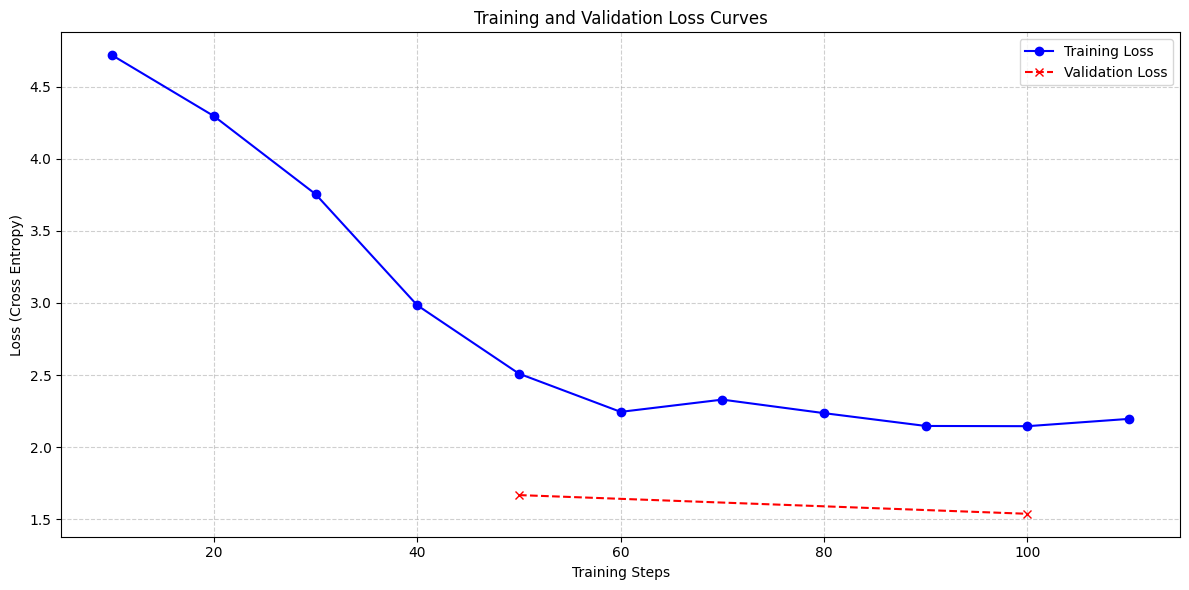


--- PHÂN TÍCH PERPLEXITY (PPL) ---
Validation Loss cuối cùng: 1.5380
Perplexity (PPL) cuối cùng: 4.6554


In [ ]:
import matplotlib.pyplot as plt

# TODO: Lấy training history từ trainer
# Gợi ý: trainer.state.log_history
log_history = trainer.state.log_history
train_steps = []
train_losses = []
eval_steps = []
eval_losses = []
for log in log_history:
    if 'loss' in log:
        # Lấy Training Loss và Step
        train_losses.append(log['loss'])
        train_steps.append(log['step'])

    if 'eval_loss' in log:
        # Lấy Validation Loss và Step
        eval_losses.append(log['eval_loss'])
        eval_steps.append(log['step'])

print(f"✅ Đã trích xuất {len(train_losses)} điểm Training Loss và {len(eval_losses)} điểm Validation Loss.")

# TODO: Extract training loss và validation loss

# TODO: Vẽ loss curves
# - Training loss vs steps
# - Validation loss vs steps
plt.figure(figsize=(12, 6))
plt.plot(train_steps, train_losses, label='Training Loss', marker='o', linestyle='-', color='blue')
if eval_losses:
    plt.plot(eval_steps, eval_losses, label='Validation Loss', marker='x', linestyle='--', color='red')

plt.title('Training and Validation Loss Curves')
plt.xlabel('Training Steps')
plt.ylabel('Loss (Cross Entropy)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# TODO: Tính perplexity
# perplexity = exp(loss)
print("\n--- PHÂN TÍCH PERPLEXITY (PPL) ---")
import math

if eval_losses:
    # Perplexity là exp(Loss)
    # Lấy Validation Loss cuối cùng để đánh giá
    final_eval_loss = eval_losses[-1]

    # TODO: Tính perplexity
    perplexity = math.exp(final_eval_loss)

    print(f"Validation Loss cuối cùng: {final_eval_loss:.4f}")
    print(f"Perplexity (PPL) cuối cùng: {perplexity:.4f}")

else:
    print("Không tìm thấy Validation Loss để tính Perplexity.")

Demo

In [ ]:
import gradio as gr

def gradio_predict(question):
    """
    Hàm này đóng vai trò trung gian.
    Nó nhận input từ Gradio (question) và gọi hàm generate_response
    với biến 'model' (đang là biến global).
    """
    # Gọi hàm generate_response của bạn, giữ nguyên logic cũ
    # model: là biến model global bạn đã load trước đó
    try:
        # Kiểm tra xem các biến global quan trọng có tồn tại không
        if 'finetuned_model' not in globals():
            return "Lỗi: Biến 'finetuned_model' chưa được định nghĩa."
        if 'tokenizer' not in globals():
            return "Lỗi: Biến 'tokenizer' chưa được định nghĩa."
        if 'extract_assistant_response' not in globals():
            return "Lỗi: Hàm 'extract_assistant_response' chưa được định nghĩa/chạy."

        # Gọi hàm gốc
        response = generate_response(finetuned_model, question)
        return response

    except Exception as e:
        # In lỗi chi tiết ra console để debug
        traceback.print_exc()
        # Trả về thông báo lỗi lên giao diện web
        return f"🚨 ĐÃ XẢY RA LỖI PYTHON:\n{str(e)}"

demo = gr.Interface(
    fn=gradio_predict,  # Gọi hàm wrapper
    inputs=gr.Textbox(
        lines=2,
        placeholder="Ví dụ: What are the symptoms of diabetes?",
        label="Câu hỏi (Question)"
    ),
    examples=[
        ["What are the symptoms of diabetes?"],
        ["How to treat a common cold?"],
    ],
    outputs = gr.Textbox(
        label="Phản hồi của AI",
        lines=5,
        scale=1
    ),
    title="🩺 Medical AI Assistant (Qwen2-1.5B)",
    description="Hỏi đáp y tế với mô hình đã được Fine-tuned."
)

# --- 3. Chạy Demo ---
# share=True để tạo link public nếu chạy trên Colab
demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5a5c99ead04777ec2e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Demo RAG

In [ ]:
import gradio as gr
from langchain.chains import RetrievalQA

# --- HÀM DỰ ĐOÁN RAG ---

def rag_predict(question):
    """
    Hàm nhận câu hỏi, thực thi chuỗi RAG (qa_chain), và định dạng kết quả
    bao gồm câu trả lời của mô hình và các nguồn tài liệu.
    """
    # Đảm bảo 'qa_chain' đã được định nghĩa
    if 'qa_chain' not in globals():
        return "🚨 Lỗi hệ thống: Chuỗi RAG (qa_chain) chưa được khởi tạo. Vui lòng chạy lại Bước 1 và Bước 2."

    try:
        # Thực thi chuỗi RAG
        result = qa_chain.invoke({"query": question})

        answer = result['result']
        source_docs = result['source_documents']

        # Định dạng nguồn tài liệu
        sources_text = "\n\n---\n\n📚 **Nguồn tham khảo:**\n"

        if source_docs:
            for i, doc in enumerate(source_docs):
                # Hiển thị 250 ký tự đầu tiên của đoạn văn bản được truy xuất
                sources_text += f"- **Nguồn {i+1}:** {doc.page_content[:250]}...\n"
        else:
            sources_text += "- Không tìm thấy tài liệu liên quan trong Knowledge Base (LLM trả lời dựa trên kiến thức nội tại)."

        return answer + sources_text

    except Exception as e:
        traceback.print_exc()
        return f"🚨 ĐÃ XẢY RA LỖI KHI GỌI RAG:\n{str(e)}"

# --- GIAO DIỆN GRADIO ---

demo = gr.Interface(
    fn=rag_predict,  # GỌI HÀM RAG
    inputs=gr.Textbox(
        lines=2,
        placeholder="Ví dụ: Tôi bị đau cổ tay vào ban đêm. Nguyên nhân có thể là gì?",
        label="Câu hỏi (Question)"
    ),
    examples=[
        ["What are the symptoms of Carpal Tunnel Syndrome?"],
        ["How can blood sugar levels be kept under control?"],
    ],
    outputs = gr.Textbox(
        label="Phản hồi của AI (Đã được RAG bổ sung)",
        lines=10,
        scale=1
    ),
    title="🩺 Medical AI Assistant (Qwen RAG)",
    description="Hệ thống RAG sử dụng mô hình Qwen Fine-tuned và Knowledge Base y tế."
)

# --- 4. Chạy Demo ---
demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a4d75226f3ca5b4bbd.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## 4.3. Phân tích kết quả

**TODO:** Trả lời các câu hỏi phân tích

### 1. Mô hình có bị overfitting không? Tại sao?
[Điền câu trả lời của bạn - phân tích dựa trên loss curves]
- Training Loss (Đường màu xanh): Giảm mạnh từ ban đầu (khoảng 4.6) xuống còn khoảng 2.15 tại Step 90. Sau Step 60, Loss có xu hướng giảm chậm lại, chững lại, hoặc tăng nhẹ trở lại (2.2).
- Validation Loss (Đường màu đỏ): Giảm từ 1.71 (Step 50) xuống 1.5378 (Step 100).
- Mô hình không bị overfit do loss giảm trên tập train cũng như tập validation. Tuy nhiên đến training step 60 thì loss trên tập train bắt đầu chững lại thậm chí còn tăng có thể do mô hình gần đạt giới hạn hội tụ.

### 2. Những cải tiến nào có thể áp dụng để tăng hiệu suất?
[Điền câu trả lời của bạn - liệt kê ít nhất 3 cải tiến]
- Tăng số lượng epoch cũng nhưu training step vì validation loss vẫn có dấu hiệu sẽ giảm. (Hiện tại do giới hạn GPU, thử nghiệm chạy 1 epoch đã gần full limit free GPU của colab)
- Điều chỉnh learning rate hoặc dùng các kĩ thuật khác để giúp mô hình thoát khỏi local min khi loss bắt đầu chững lại
- Tăng kích thước tập dữ liệu vì model hiện tại chỉ mới dùng 1000 bản ghi.

### 3. Trong thực tế production, cần lưu ý gì khi deploy fine-tuned model?
[Điền câu trả lời của bạn - đề cập đến safety, performance, monitoring, etc.]
- Safety: Vì mô hình fine-tune về y tế nên nếu trả lời sai do hallucination thì sẽ gây ra hậu quả nghiêm trọng. Cần thêm các nhắc nhở rằng câu trả lời chỉ mang tính tham khảo và người dùng nên tham khảo ý kiến của chuyên gia.

- Performance: Để ý thời gian trả lời câu hỏi, nếu trả lời lâu quá thì cần tối ưu hóa time, nếu trả lời sai thì cần train model tốt hơn.

- Monitoring: Theo dõi chất lượng câu hỏi của người dùng, check xem input người dùng in production nếu không giống với train set thì có hoạt động tốt không? Nếu cần thì sẽ phải train lại thêm các data mới.

---

# 🎁 BONUS (nếu có)

## Weights & Biases Integration

In [ ]:
# TODO: Setup wandb nếu muốn làm bonus
!pip install -q wandb
import wandb
wandb.login()
# Thêm report_to="wandb" vào TrainingArguments

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: akaksakanzjzn (akaksakanzjzn-none) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## Early Stopping Implementation

In [ ]:
# TODO: Implement early stopping callback
from transformers import EarlyStoppingCallback
early_stopping = EarlyStoppingCallback(early_stopping_patience=3)
# Thêm vào Trainer: callbacks=[early_stopping]

## Gradio Demo

In [ ]:
# TODO: Tạo Gradio demo nếu muốn làm bonus
!pip install -q gradio
import gradio as gr

---

# 📝 KẾT LUẬN

**TODO:** Viết tóm tắt về những gì bạn đã làm, kết quả đạt được, và những khó khăn gặp phải

## Tóm tắt công việc
[Điền tóm tắt của bạn]

## Kết quả đạt được
1. Hiệu suất mô hình
- Hội tụ tốt: Training Loss giảm mạnh từ khoảng 4.6 xuống 2.15.

- Chất lượng tổng quát hóa: Validation Loss giảm từ 1.71 xuống 1.5378, cho thấy mô hình đã học được các mẫu mới và có khả năng tổng quát hóa tốt.

- Perplexity (PPL): Đạt mức 4.6545, là một con số rất khả quan đối với một mô hình 1.5B, xác nhận mô hình có độ tự tin cao trong việc dự đoán văn bản y tế.

- Chất lượng phản hồi: Mô hình đã Fine-tuned có khả năng tạo ra các phản hồi chính xác, chi tiết, và tuân thủ chặt chẽ hơn vai trò trợ lý y tế chuyên nghiệp so với mô hình gốc.

2. Tối ưu kỹ thuật
- Tối ưu VRAM: Việc sử dụng LoRA 4-bit quantization thành công giúp giảm đáng kể lượng VRAM cần thiết, cho phép quá trình Fine-tuning diễn ra trên phần cứng GPU có bộ nhớ hạn chế.

- Thời gian Inference: Thời gian phản hồi trên Demo khá nhanh (latency thấp), phù hợp cho các ứng dụng yêu cầu trả lời tức thời.

## Khó khăn gặp phải và cách giải quyết
[Điền khó khăn và cách giải quyết]
- Lỗi Out of Memory (OOM): Gặp lỗi VRAM bị đầy khi sử dụng Batch Size lớn và epoch = 3.
=> Giảm Batch Size (per_device_train_batch_size=2) và áp dụng Gradient Accumulation (gradient_accumulation_steps=8) cũng như giảm epoch xuống 0.1 để chạy thử từ đầu đến cuối xong tăng dần dần lên 1. Ngoài ra, em đã phải dùng 3 gmail khác nhau vì hết limit GPU của colab.
- Ngoài ra khi code em có rất nhiều lỗi khi code nhưng em đã fix bug bằng cách print ra lỗi hoặc check logic qua từng step trong vòng lặp

## Bài học kinh nghiệm
[Điền bài học của bạn]
- Ưu tiên VRAM (QLoRA): Đối với LLM, việc kiểm soát VRAM là yếu tố quan trọng để tối ưu hóa về thời gian cũng như chi phí

- Khi VRAM ít, điều chỉnh epoch, Batch Size, Gradient Accumulation là kỹ thuật để duy trì chất lượng hội tụ.

- Khi deploy lên demo cần gọi trace error để keep track lỗi vì trên demo không có Terminal.
---